In [1]:
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

2025-04-18 01:21:14.772346: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 01:21:14.814289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-18 01:21:15.437092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import tensorflow as tf
from tensorflow.keras import layers

class DynamicTanh(layers.Layer):
    def __init__(self, **kwargs):
        super(DynamicTanh, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.alpha = self.add_weight(
            name="alpha",
            shape=(1,),
            initializer=tf.keras.initializers.Ones(),
            trainable=True
        )
        self.beta = self.add_weight(
            name="beta",
            shape=(1,),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True
        )
        super(DynamicTanh, self).build(input_shape)
    
    def call(self, inputs):
        return tf.math.tanh(self.alpha * inputs + self.beta)




In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Given aggregation string is not implemented. Use 'mean' or 'max'.")

# ---------------------------
# Linformer Multi-Head Attention
# ---------------------------
class LinformerMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, proj_dim, **kwargs):
        """
        Args:
          d_model: Dimensionality of the model.
          num_heads: Number of attention heads.
          proj_dim: The projection dimension to which keys and values will be reduced.
        """
        super(LinformerMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.proj_dim = proj_dim

    def build(self, input_shape):
        # input_shape: (batch_size, seq_len, d_model)
        self.seq_len = input_shape[1]
        # Standard dense weight matrices for Q, K, and V.

        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)

        self.F = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_F")
        super(LinformerMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose to shape: (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        v = tf.matmul(x, self.wv)


        v = self.split_heads(v, batch_size)


        v_proj = tf.einsum('bhnd, hnr -> bhrd', v, self.F)

        attn_output = v_proj
        # Concatenate heads.
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(attn_output, (batch_size, -1, self.d_model))
        output = self.dense(concat_output)
        return output
# ---------------------------
# Clustered Linformer Multi-Head Attention
# ---------------------------
class ClusteredLinformerAttention(layers.Layer):
    def __init__(self, d_model, num_heads, num_clusters=4, **kwargs):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0
        self.d_model      = d_model
        self.num_heads    = num_heads
        self.depth        = d_model // num_heads
        self.num_clusters = num_clusters

        self.wv  = self.add_weight(
            shape=(d_model, d_model), initializer='glorot_uniform',
            trainable=True, name='wv')
        self.out = layers.Dense(d_model, name='out')

    def build(self, input_shape):
        self.seq_len = input_shape[1]
        # compute chunk size with ceiling division
        chunk_size = (self.seq_len + self.num_clusters - 1) // self.num_clusters
        self.chunk_size = chunk_size

        # learnable cluster‑weights: (heads, clusters, chunk_size)
        self.cluster_W = self.add_weight(
            shape=(self.num_heads, self.num_clusters, chunk_size),
            initializer='glorot_uniform',
            trainable=True,
            name='cluster_weights')
        super().build(input_shape)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, [0,2,1,3])  # (B, H, N, depth)

    def call(self, x):
        # Debug: input shape
        # tf.print("Input x shape:", tf.shape(x))  # (B, N, d_model)
        B = tf.shape(x)[0]
        # 1) V projection
        v = tf.matmul(x, self.wv)               # (B, N, d_model)
        # tf.print("v (after wv) shape:", tf.shape(v))
        v = self.split_heads(v, B)             # (B, H, N, depth)
        # tf.print("v (after split_heads) shape:", tf.shape(v))

        # 2) pad to (chunk_size * num_clusters)
        pad_total = self.chunk_size * self.num_clusters - self.seq_len
        v_padded = tf.pad(v, [[0,0],[0,0],[0,pad_total],[0,0]])
        # tf.print("v_padded shape:", tf.shape(v_padded))

        # 3) chunkify
        v_chunks = tf.reshape(
            v_padded,
            (B, self.num_heads, self.num_clusters, self.chunk_size, self.depth)
        )  # (B, H, C, l, d)
        # tf.print("v_chunks shape:", tf.shape(v_chunks))

        # 4) weighted combine per cluster
        v_proj = tf.einsum('bhcld,hcl->bhcd', v_chunks, self.cluster_W)
        # tf.print("v_proj shape:", tf.shape(v_proj))  # (B, H, C, depth)

        # 5) merge heads & clusters
        v_proj = tf.transpose(v_proj, [0,2,1,3])  # (B, C, H, depth)
        v_proj = tf.reshape(v_proj, (B, self.num_clusters, self.d_model))  # (B, C, d_model)
        # tf.print("merged v_proj shape:", tf.shape(v_proj))

        # final linear
        output = self.out(v_proj)               # (B, C, d_model)
        # tf.print("output shape:", tf.shape(output))
        return output

# ---------------------------
# Linformer Transformer Block
# ---------------------------
class LinformerTransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, proj_dim, **kwargs):
        super(LinformerTransformerBlock, self).__init__(**kwargs)
        self.attention = ClusteredLinformerAttention(d_model, num_heads, proj_dim)
        self.dynamic_tanh1 = DynamicTanh()
        self.dynamic_tanh2 = DynamicTanh()
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])

    def call(self, x):
        attn_output = self.attention(x)
        out1 = self.dynamic_tanh1(x + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.dynamic_tanh2(out1 + ffn_output)
        return out2
# ---------------------------
# Linformer Transformer Classifier Model
# ---------------------------
def build_linformer_transformer_classifier(num_particles, feature_dim,
                                             d_model=16, d_ff=16, output_dim=16,
                                             num_heads=8, proj_dim=8):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - Multiple Linformer transformer blocks.
      - Aggregation over the sequence dimension.
      - A final linear output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    x = layers.Dense(d_model, activation='relu')(inputs)
    
    x = LinformerTransformerBlock(d_model, d_ff, output_dim, num_heads, proj_dim)(x)    
    
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    x = layers.Dense(d_model, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ---------------------------
# Example Training Setup
# ---------------------------
import numpy as np
from sklearn.model_selection import train_test_split

# Load your data.
x_train = np.load("/j-jepa-vol/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
y_train = np.load("/j-jepa-vol/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

# 80/20 split for training and validation.
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# Determine input dimensions from data.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the Linformer transformer classifier.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=1)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()




2025-04-18 01:21:17.546813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22399 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:cf:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 3)]           0         
                                                                 
 dense (Dense)               (None, 32, 16)            64        
                                                                 
 linformer_transformer_bloc  (None, 32, 16)            1332      
 k (LinformerTransformerBlo                                      
 ck)                                                             
                                                                 
 aggregation_layer (Aggrega  (None, 16)                0         
 tionLayer)                                                      
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                             

In [5]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=500, 
    batch_size=1024)

Epoch 1/500


2025-04-18 01:21:20.031394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-04-18 01:21:20.036433: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f97a0003bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-18 01:21:20.036466: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-18 01:21:20.041798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-18 01:21:20.104771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-04-18 01:21:20.204206: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

485/485 [==============================] - 5s 4ms/step - loss: 1.2067 - accuracy: 0.5017 - val_loss: 1.0052 - val_accuracy: 0.6072
Epoch 2/500
485/485 [==============================] - 2s 4ms/step - loss: 0.9449 - accuracy: 0.6356 - val_loss: 0.9057 - val_accuracy: 0.6560
Epoch 3/500
485/485 [==============================] - 2s 4ms/step - loss: 0.8802 - accuracy: 0.6682 - val_loss: 0.8601 - val_accuracy: 0.6808
Epoch 4/500
485/485 [==============================] - 2s 4ms/step - loss: 0.8364 - accuracy: 0.6898 - val_loss: 0.8257 - val_accuracy: 0.6947
Epoch 5/500
485/485 [==============================] - 2s 4ms/step - loss: 0.8044 - accuracy: 0.7055 - val_loss: 0.7916 - val_accuracy: 0.7115
Epoch 6/500
485/485 [==============================] - 2s 3ms/step - loss: 0.7801 - accuracy: 0.7163 - val_loss: 0.7693 - val_accuracy: 0.7212
Epoch 7/500
485/485 [==============================] - 2s 3ms/step - loss: 0.7631 - accuracy: 0.7236 - val_loss: 0.7600 - val_accuracy: 0.7256
Epoch 8/500

In [6]:
model.save_weights('1layerLinformerCompressOne32partCLuster.weights.h5')

In [7]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    # Create a concrete function from the Keras model.
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    # Convert the model to a frozen graph.
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Import the graph_def into a new graph.
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

# Assuming x_val is already loaded and has shape (num_samples, features, ...)
# For a single event, we use a batch size of 1.
input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
# Warm-up: Run one inference to load any lazy initializations.
import numpy as np
import time

# Warm-up (optional but recommended)
_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

# Compute average inference time per event in seconds, then convert to nanoseconds
avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2025-04-18 01:35:04.910559: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-18 01:35:04.910678: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2025-04-18 01:35:04.912067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22399 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:cf:00.0, compute capability: 8.6


Total FLOPs for a single inference:
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Pl

In [8]:
x_val = np.load("/j-jepa-vol/l1-jet-id/data/jetid/processed/x_val_robust_32const_ptetaphi.npy")
y_val = np.load("/j-jepa-vol/l1-jet-id/data/jetid/processed/y_val_robust_32const_ptetaphi.npy")

In [9]:
xout = np.argmax(model(x_val, training=False),1)
yout = np.argmax(y_val,1)

In [10]:
import sklearn
sklearn.metrics.accuracy_score(xout,yout)

0.7759423076923077

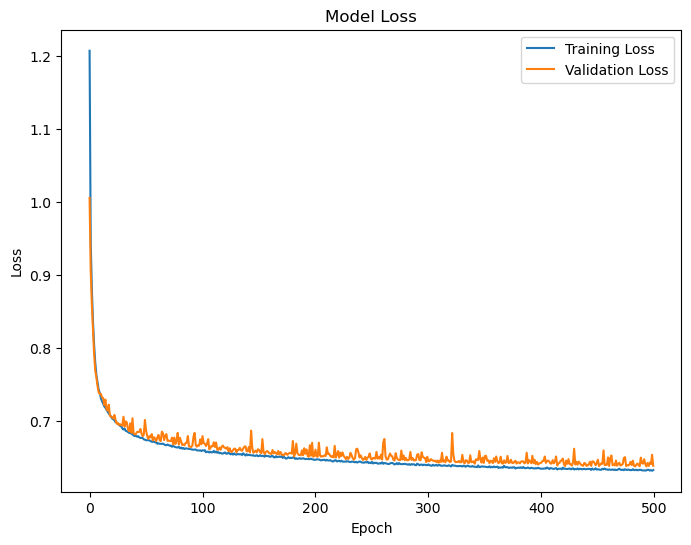

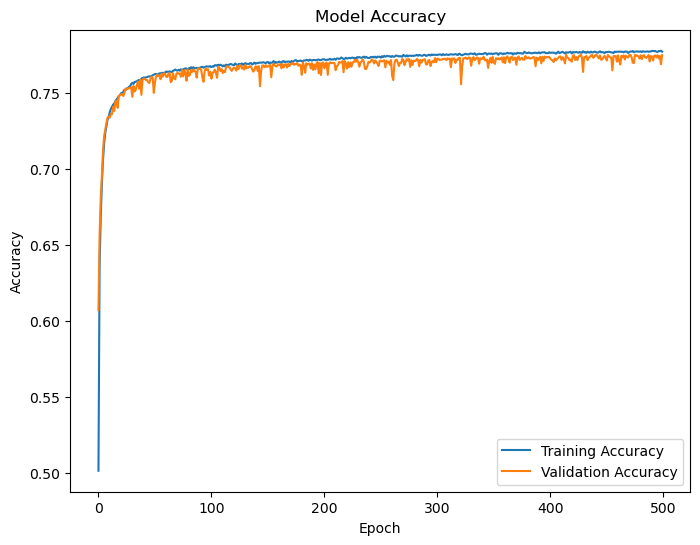

In [11]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


1/FPR at TPR=80% for each class:
g: 1/FPR = 8.906259384786992
q: 1/FPR = 8.111648794084626
W: 1/FPR = 27.112749575884116
Z: 1/FPR = 30.32588699080158
t: 1/FPR = 24.291988756148978
Average 1/FPR across classes: 19.749706700341257

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.8700
q: accuracy = 0.8618
W: accuracy = 0.9303
Z: accuracy = 0.9334
t: accuracy = 0.9267
Average accuracy across classes: 0.9045


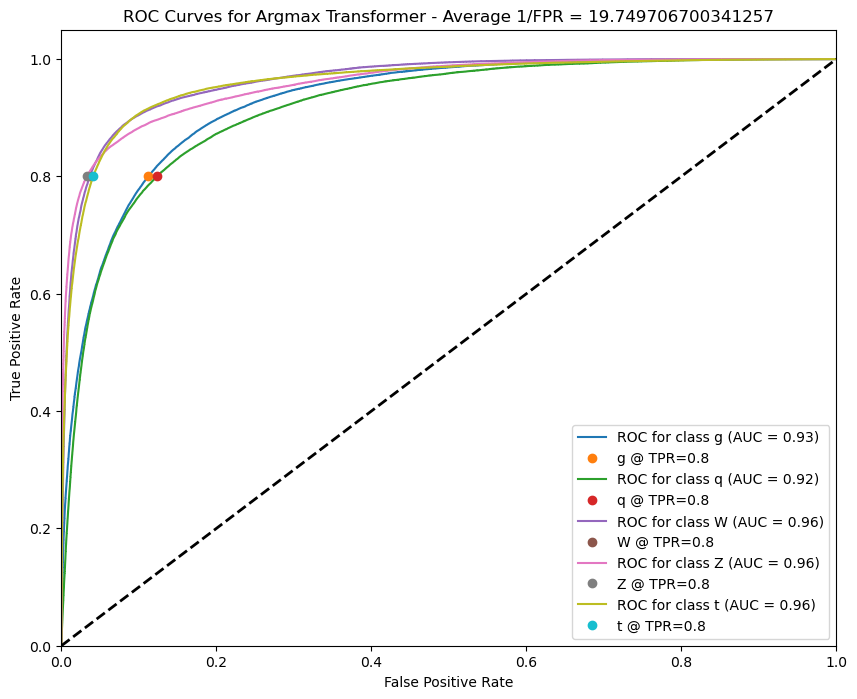

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()

